In [1]:
!pip install scikit-optimize
!pip install barplots
!pip install extra_keras_metrics
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence

     |████████████████████████████████| 495 kB 4.1 MB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=177539 sha256=20ff56ee2f4224a10468e90045547519efe0b317ddd7fd17c93b215792ae310d
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy
     |████████████████████████████████| 101 kB 3.7 MB/s 
  Created wheel for barplots: filename=barplots-1.1.11-py3-none-any.whl size=17877 sha256=cd5a862c06ca74189ae6ebbbf0c5817914474a523a45968d67d0574146d2728c
  Stored in directory: /root/.cache/pip/wheels/2a/53/e4/1c71fe6cb782f2f43b23872deea5369ad81c11118361558728
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=466bcaa3039ea7ce228ea1c8a19bbc6667a6218885d37f743211211090e4a407
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=comp

In [2]:
from epigenomic_dataset import load_epigenomes
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from barplots import barplots
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence
import matplotlib.pyplot as plt # A standard plotting library

## Data retrieval
First, we retrieve the data and impute and scale them.

In [3]:
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
cell_line = "H1"

X, y = active_enhancers_vs_inactive_enhancers(
    cell_line=cell_line,
    min_active_tpm_value=0.5,
    max_inactive_tpm_value=0.5, 
    binarize=True
)

X = X.reset_index()
bed = X[X.columns[:5]]

In [5]:
def build_sequence(
    X: pd.DataFrame,
    y: np.ndarray,
    genome: Genome,
    batch_size: int
) -> MixedSequence:
    return MixedSequence(
        x=BedSequence(
            genome,
            X,
            batch_size=batch_size,
        ),
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [6]:
mixed_sequence = build_sequence(bed, y[cell_line].values, genome, 1024)
inputs, outputs = list(zip(*mixed_sequence))
inputs = np.vstack(inputs)
outputs = np.hstack(outputs)
inputs = inputs.reshape(-1, 256*4)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
from sklearn.decomposition import FactorAnalysis

def mfa(x:np.ndarray, n_components:int=2)->np.ndarray:
    return FactorAnalysis(n_components=n_components, random_state=42).fit_transform(x)


Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering sequence.:   0%|          | 0/1 [00:00<?, ?it/s]

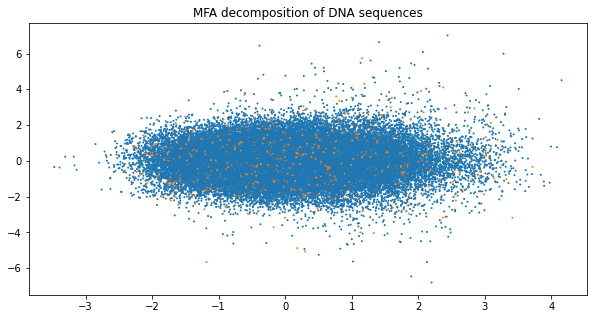

In [8]:
from sklearn.decomposition import FactorAnalysis
colors = np.array([
    "tab:blue",
    "tab:orange",
])

train_sequence = build_sequence(bed, y.values, genome, batch_size=len(bed))
X = train_sequence.rasterize()[0].reshape(-1, 256*4).astype(int)

xseries = []
yseries = []
for example in mfa(X):
    xseries.append(example[0])
    yseries.append(example[1])

tcolors = []
for color in colors[y.values.astype(int)]:
    tcolors.append(color[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.scatter(xseries, yseries, s=1, c=tcolors)
axes.set_title(f"MFA decomposition of DNA sequences")
plt.show()

## Bayesian Optimization for Model Selection


In [9]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [10]:
#Definition of the dimensions in which we want to find the best hyper parameter's values for the task.
dim_num_conv_units_2 = Categorical(categories=[32,64,128], name=
                                    'num_conv_units_2')
dim_num_dense_nodes_1 = Categorical(categories=[16,32,64], name=
                                    'num_dense_nodes_1')
dim_num_dense_nodes_2 = Categorical(categories=[16,32,64], name=
                                    'num_dense_nodes_2')
dim_kernel_size_2 = Categorical(categories=[5, 10], 
                               name='kernel_size_2')
dim_dropout_prob = Categorical(categories=[0.1, 0.2, 0.3, 0.4, 0.5], 
                               name='dropout_prob')
    
dimensions = [dim_num_conv_units_2,
              dim_num_dense_nodes_2,
              dim_num_dense_nodes_1,
              dim_kernel_size_2,
              dim_dropout_prob]

In [11]:
from tensorflow.keras.layers import Dense, Input, Conv1D, Conv2D, Reshape, Flatten, MaxPool1D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.optimizers import Nadam

def create_model(    
    num_conv_units_2,           
    num_dense_nodes_2,
    num_dense_nodes_1,
    kernel_size_2,
    dropout_prob):
    
    model = Sequential()

    model.add(Input((256, 4)))
    model.add(Conv1D(64, kernel_size=5, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=5, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kernel_size=5, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Conv1D(num_conv_units_2, kernel_size=int(kernel_size_2), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Flatten())
    model.add(Dense(num_dense_nodes_2, activation="relu"))
    model.add(Dropout(dropout_prob))
    model.add(Dense(num_dense_nodes_1, activation="relu"))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=Nadam(0.0002),
        metrics=['accuracy', AUC(curve='ROC', name='AUROC'),  AUC(curve='PR', name='AUPRC')]
    )

    return model

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 1
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

for holdout_number, (train_indices, test_indices) in enumerate(holdouts_generator.split(bed, y)):
    X_train, X_test = bed.iloc[train_indices], bed.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

train_sequence = build_sequence(X_train, y_train.values, genome, batch_size=128)
test_sequence = build_sequence(X_test, y_test.values, genome, batch_size=128)

In [15]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

n_calls = 0
@use_named_args(dimensions=dimensions)
def fitness(num_conv_units_2, num_dense_nodes_2, num_dense_nodes_1, kernel_size_2, dropout_prob):

    # Print the hyper-parameters.
    print('num_conv_units_2:', num_conv_units_2)
    print('num_dense_nodes_2:', num_dense_nodes_2)
    print('num_dense_nodes_1:', num_dense_nodes_1)
    print('kernel_size_2:', kernel_size_2)
    print('dropout_prob:', dropout_prob)
    
    # Create the neural network with these hyper-parameters.
    model = create_model(num_conv_units_2=num_conv_units_2,
                         num_dense_nodes_2=num_dense_nodes_2,
                         num_dense_nodes_1=num_dense_nodes_1,
                         kernel_size_2=kernel_size_2,
                         dropout_prob = dropout_prob)

    # Training phase
    history = model.fit(train_sequence,
                        epochs=100,
                        validation_data=test_sequence,
                        verbose=2,
                        callbacks = [EarlyStopping(monitor = "val_loss", patience = 3)])

    # I use this metric because I want to put more importance to the positive examples
    val_loss = history.history['val_loss'][-1]

    global n_calls 
    n_calls += 1
    
    # Print the result of the AUPRC metric over the validation set.
    print()
    print("n_call:"+str(n_calls)+"val_loss: {0:.2%}".format(val_loss))
    print()

    del model
    
    K.clear_session()
    
    # Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # We need to negate the result so it can be minimized.
    return val_loss

In [16]:
%%time

default_parameters = [64, 64, 64, 10, 0.1]
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=40,
                            x0=default_parameters)

num_conv_units_2: 64
num_dense_nodes_2: 64
num_dense_nodes_1: 64
kernel_size_2: 10
dropout_prob: 0.1
Epoch 1/100
396/396 - 48s - loss: 0.2053 - accuracy: 0.9467 - AUROC: 0.6169 - AUPRC: 0.0776 - val_loss: 0.2955 - val_accuracy: 0.9306 - val_AUROC: 0.6598 - val_AUPRC: 0.1248
Epoch 2/100
396/396 - 15s - loss: 0.1714 - accuracy: 0.9526 - AUROC: 0.7428 - AUPRC: 0.1934 - val_loss: 0.1829 - val_accuracy: 0.9512 - val_AUROC: 0.6752 - val_AUPRC: 0.1449
Epoch 3/100
396/396 - 15s - loss: 0.1500 - accuracy: 0.9546 - AUROC: 0.8319 - AUPRC: 0.3263 - val_loss: 0.1927 - val_accuracy: 0.9517 - val_AUROC: 0.6593 - val_AUPRC: 0.1312
Epoch 4/100
396/396 - 15s - loss: 0.1159 - accuracy: 0.9613 - AUROC: 0.9186 - AUPRC: 0.5507 - val_loss: 0.2170 - val_accuracy: 0.9504 - val_AUROC: 0.6386 - val_AUPRC: 0.0993
Epoch 5/100
396/396 - 15s - loss: 0.0707 - accuracy: 0.9757 - AUROC: 0.9762 - AUPRC: 0.8166 - val_loss: 0.2723 - val_accuracy: 0.9482 - val_AUROC: 0.6120 - val_AUPRC: 0.0987

n_call:1val_loss: 27.23%

nu

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


num_conv_units_2: 32
num_dense_nodes_2: 32
num_dense_nodes_1: 16
kernel_size_2: 5
dropout_prob: 0.5
Epoch 1/100
396/396 - 18s - loss: 0.4451 - accuracy: 0.8165 - AUROC: 0.5356 - AUPRC: 0.0519 - val_loss: 1.2596 - val_accuracy: 0.1231 - val_AUROC: 0.6429 - val_AUPRC: 0.1122
Epoch 2/100
396/396 - 14s - loss: 0.2781 - accuracy: 0.9317 - AUROC: 0.5815 - AUPRC: 0.0611 - val_loss: 0.1819 - val_accuracy: 0.9520 - val_AUROC: 0.6712 - val_AUPRC: 0.1462
Epoch 3/100
396/396 - 14s - loss: 0.2462 - accuracy: 0.9439 - AUROC: 0.6187 - AUPRC: 0.0726 - val_loss: 0.1830 - val_accuracy: 0.9518 - val_AUROC: 0.6638 - val_AUPRC: 0.1489
Epoch 4/100
396/396 - 14s - loss: 0.2347 - accuracy: 0.9479 - AUROC: 0.6320 - AUPRC: 0.0815 - val_loss: 0.1828 - val_accuracy: 0.9519 - val_AUROC: 0.6805 - val_AUPRC: 0.1582
Epoch 5/100
396/396 - 14s - loss: 0.2219 - accuracy: 0.9497 - AUROC: 0.6577 - AUPRC: 0.0936 - val_loss: 0.1811 - val_accuracy: 0.9519 - val_AUROC: 0.6788 - val_AUPRC: 0.1576
Epoch 6/100
396/396 - 14s - lo

In [17]:
results = sorted(zip(search_result.func_vals, search_result.x_iters))

In [18]:
pd.DataFrame(results).to_csv("best_models_enhancers_0.5_cnn.csv")

In [19]:
results

[(0.18651911616325378, [32, 32, 16, 5, 0.5]),
 (0.1885860711336136, [32, 16, 16, 5, 0.5]),
 (0.18876180052757263, [32, 64, 32, 5, 0.4]),
 (0.18971650302410126, [32, 32, 64, 5, 0.4]),
 (0.1899915188550949, [32, 32, 16, 5, 0.5]),
 (0.1903754025697708, [32, 16, 32, 5, 0.5]),
 (0.19085748493671417, [32, 32, 32, 5, 0.5]),
 (0.1915840208530426, [64, 16, 64, 5, 0.4]),
 (0.1919916719198227, [32, 16, 32, 5, 0.4]),
 (0.19210894405841827, [32, 16, 32, 10, 0.5]),
 (0.19244442880153656, [32, 32, 32, 10, 0.5]),
 (0.1929842233657837, [32, 32, 16, 5, 0.4]),
 (0.19311167299747467, [32, 16, 16, 5, 0.4]),
 (0.19417792558670044, [32, 16, 64, 5, 0.5]),
 (0.19419099390506744, [64, 32, 16, 5, 0.5]),
 (0.19430968165397644, [64, 16, 64, 5, 0.5]),
 (0.1949809193611145, [32, 32, 64, 10, 0.5]),
 (0.19601020216941833, [32, 32, 64, 10, 0.2]),
 (0.19615328311920166, [32, 64, 16, 5, 0.5]),
 (0.19655205309391022, [64, 32, 32, 5, 0.4]),
 (0.196562722325325, [64, 64, 32, 5, 0.5]),
 (0.1971752941608429, [32, 64, 64, 5, 0

In [20]:
from ast import literal_eval
results = pd.read_csv("best_models_enhancers_0.5_cnn.csv")
best_configuration = literal_eval(results["1"][0])

In [21]:
op_num_conv_units_2 = best_configuration[0]
op_num_of_nodes_2 = best_configuration[1]
op_num_of_nodes_1 = best_configuration[2]
op_kernel_size_2 = best_configuration[3]
op_dropout_prob = best_configuration[4]

In [22]:
from tensorflow.keras.layers import Dense, Input, Conv1D, Conv2D, Reshape, Flatten, MaxPool1D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam
from extra_keras_metrics import get_standard_binary_metrics

def train_cnn(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: np.ndarray,
    y_test: np.ndarray,
    genome: Genome,
    batch_size: int,
    holdout_number: int
):
    """Return performance of a FFNN.
    
    Parameters
    ----------------------
    X_train: pd.DataFrame,
        Data reserved for the input during training of the model.
    X_test: pd.DataFrame,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    genome: Genome,
        The genome object to use.
    holdout_number: int,
        Number of the holdout.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    train_sequence = build_sequence(X_train, y_train, genome, batch_size=batch_size)
    test_sequence = build_sequence(X_test, y_test, genome, batch_size=batch_size)
    
    cnn = Sequential([
        Input((256, 4)),
        Conv1D(64, kernel_size=5, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool1D(),
        Conv1D(64, kernel_size=5, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool1D(),
        Conv1D(64, kernel_size=5, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool1D(),
        Conv1D(op_num_conv_units_2, kernel_size=int(op_kernel_size_2), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool1D(),
        Flatten(),
        Dense(op_num_of_nodes_2, activation="relu"),
        Dropout(op_dropout_prob),
        Dense(op_num_of_nodes_1, activation="relu"),
        Dropout(op_dropout_prob),
        Dense(1, activation="sigmoid")
    ])
    cnn.compile(
        loss="binary_crossentropy",
        optimizer=Nadam(0.0002),
        metrics=get_standard_binary_metrics()
    )
    
    cnn.summary()
    
    history = pd.DataFrame(cnn.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=100,
        verbose=False,
        callbacks=[
            EarlyStopping(monitor = "val_loss", patience = 3),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(cnn.metrics_names, cnn.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(cnn.metrics_names, cnn.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = "CNN"
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

### Training of the Models

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create a list to store all the computed performance
all_performance = []
number_of_splits = 10
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(holdouts_generator.split(bed, y)),
    total=number_of_splits,
    desc="Computing holdouts"
):
    X_train, X_test = bed.iloc[train_indices], bed.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    # We compute the model performance
    history, performance = train_cnn(
        X_train, X_test, y_train.values, y_test.values,
        genome,
        batch_size=128,
        holdout_number=holdout_number
    )
    # We chain the computed performance to the performance list
    all_performance.append(performance)

    
# We convert the computed performance list into a DataFrame
all_performance = pd.concat(all_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 64)            2

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_4 (Batch (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 128, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_16 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_20 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_24 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_28 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_29 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_32 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 256, 64)           1344      
_________________________________________________________________
batch_normalization_36 (Batc (None, 256, 64)           256       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 128, 64)           20544     
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 64)           256       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 64, 64)           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [24]:
all_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,fall_out,mcc,run_type,model_name,holdout_number
0,0.152866,0.952003,0.000000,0.000000,0.846697,0.261331,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,train,CNN,0
1,0.186015,0.951963,0.000000,0.000000,0.679000,0.140522,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,test,CNN,0
0,0.149847,0.952181,0.005761,0.736842,0.854552,0.288989,0.011433,0.502829,0.999896,0.994239,0.000104,0.062439,train,CNN,1
1,0.202469,0.951805,0.000000,0.000000,0.651144,0.123910,0.000000,0.499917,0.999834,1.000000,0.000166,-0.002824,test,CNN,1
0,0.150907,0.952003,0.000000,0.000000,0.853773,0.277427,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,train,CNN,2
1,0.195265,0.951963,0.000000,0.000000,0.656071,0.119778,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,test,CNN,2
0,0.158279,0.952003,0.001235,0.500000,0.817294,0.234954,0.002463,0.500586,0.999938,0.998765,0.000062,0.023021,train,CNN,3
1,0.190888,0.951963,0.000000,0.000000,0.652280,0.135798,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,test,CNN,3
0,0.139218,0.952003,0.000000,0.000000,0.895127,0.331009,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,train,CNN,4
1,0.192665,0.951963,0.000000,0.000000,0.672516,0.129315,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,test,CNN,4


In [25]:
all_performance.to_csv("all_performances_enhancers_0.5.cnn.csv")

In [26]:
all_performance = pd.read_csv("all_performances_enhancers_0.5.cnn.csv")

In [27]:
all_performance = all_performance.filter(items=['model_name', 'run_type', 'accuracy', 'AUROC', 'AUPRC'])
all_performance.groupby(['run_type']).mean()

,accuracy,AUROC,AUPRC
run_type,,,
test,0.951948,0.662677,0.129634
train,0.952052,0.861642,0.295690


In [ ]:
barplots(
    all_performance,
    groupby=["model_name", "run_type"],
    orientation="horizontal",
    height=8
)